<a href="https://colab.research.google.com/github/MathMachado/DSWP/blob/master/Notebooks/3DP_3_Anomaly%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carrega as Bibliotecas necessárias

In [0]:
!pip install pyod

     |████████████████████████████████| 92kB 5.7MB/s 
  Created wheel for pyod: filename=pyod-0.7.4-cp36-none-any.whl size=95437 sha256=7c757b7e543a7884ff6b0d9bac79afa000b18353302cea82c4b42eb5fa1f07c1
  Stored in directory: /root/.cache/pip/wheels/30/2f/4a/90c7bf3403325384b1c2ef5eb50d65d7467b8dd1b64a92ab82
Successfully built pyod


In [0]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
#from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
#from pyod.models.lof import LOF
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# Carrega dataframe

In [0]:
df_Titanic = sns.load_dataset('titanic')
df_Titanic = df_Titanic.dropna()
df_Titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
10,1,3,female,4.0,1,1,16.7000,S,Third,child,False,G,Southampton,yes,False
11,1,1,female,58.0,0,0,26.5500,S,First,woman,False,C,Southampton,yes,True


In [0]:
df_Titanic['fare'].describe()

count    182.000000
mean      78.919735
std       76.490774
min        0.000000
25%       29.700000
50%       57.000000
75%       90.000000
max      512.329200
Name: fare, dtype: float64

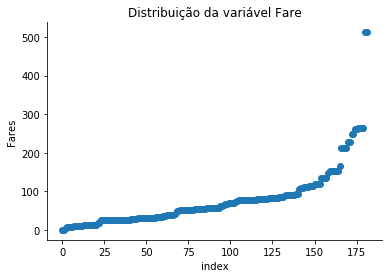

In [0]:
plt.scatter(range(df_Titanic.shape[0]), np.sort(df_Titanic['fare'].values))
plt.xlabel('index')
plt.ylabel('Fares')
plt.title("Distribuição da variável Fare")
sns.despine()

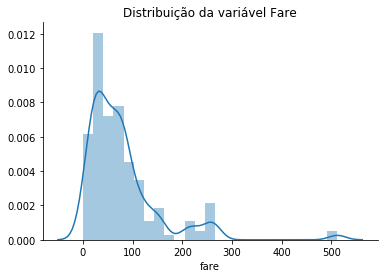

In [0]:
# Distribuição da variável 'fare'
sns.distplot(df_Titanic['fare'])
plt.title("Distribuição da variável Fare")
sns.despine()

# Kurtosis
> Kurtosis é uma medida estatística que define com que intensidade as caudas de uma distribuição diferem das caudas de uma distribuição Normal. Em outras palavras, a curtose identifica se as caudas de uma determinada distribuição contêm valores extremos.
>> A Kurtosis de uma distribuição Normal padrão é igual a 3. Portanto, se Kurtosis-3 > 0, então isso é o que chamamos de excesso de Kurtosis.
>>> Alta Kurtosis é um indicador de que os dados possuem caudas pesadas ou outliers.

# Skewness
> É o grau de distorção da distribuição, ou seja, mede a falta de simetria na distribuição de dados, diferenciando valores extremos em uma cauda versus na outra. Uma distribuição simétrica terá uma assimetria de 0.

![Skewness](https://github.com/MathMachado/Python_RFB/blob/DS_Python/Material/Skewness.png?raw=true)

Source: [Skew and Kurtosis: 2 Important Statistics terms you need to know in Data Science](https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa)

## Interpretando a Skewness (Rule of Thumb)
* Se -0.5 < Skewness < 0.5: Dados razoavelmente simétricos;
* Se -1 < Skewness < -0.5: Dados moderadamente negativa;
* Se 0.5 < Skewness < 1: Dados moderadamente positiva;
* Se Skewness < -1: Dados altamente negativa;
* Se Skewness > 1: Dados altamente positiva.

In [0]:
# Cálculo das medidas de Skewness e Kurtosis para 'fare'
print(f"Skewness: {df_Titanic['fare'].skew()}")
print(f"Kurtosis: {df_Titanic['fare'].kurt()}")

Skewness: 2.7073683146429026
Kurtosis: 10.690697893681468


Olhando para as medidas de Skewness e Kurtosis logo acima, qual a conclusão?

In [0]:
# Distribuição da variável 'age'
df_Titanic['age'].describe()

count    182.000000
mean      35.623187
std       15.671615
min        0.920000
25%       24.000000
50%       36.000000
75%       47.750000
max       80.000000
Name: age, dtype: float64

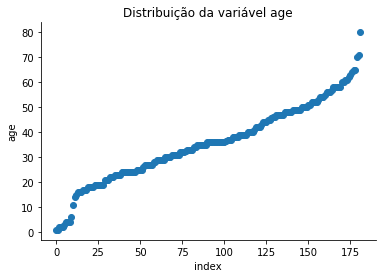

In [0]:
plt.scatter(range(df_Titanic.shape[0]), np.sort(df_Titanic['age'].values))
plt.xlabel('index')
plt.ylabel('age')
plt.title("Distribuição da variável age")
sns.despine()

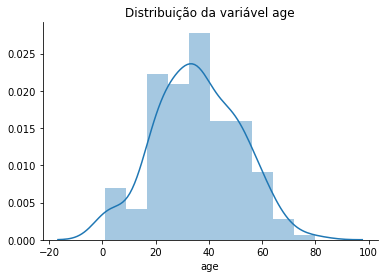

In [0]:
sns.distplot(df_Titanic['age'])
plt.title("Distribuição da variável age")
sns.despine()

In [0]:
# Cálculo das medidas de Skewness e Kurtosis para 'age'
print(f"Skewness: {df_Titanic['age'].skew()}")
print(f"Kurtosis: {df_Titanic['age'].kurt()}")

Skewness: 0.01841894050949508
Kurtosis: -0.23094277355987147


Olhando para as medidas de Skewness e Kurtosis logo acima, qual a conclusão?

# Isolation Forest Region

## Anomaly Detection para 'fare'

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


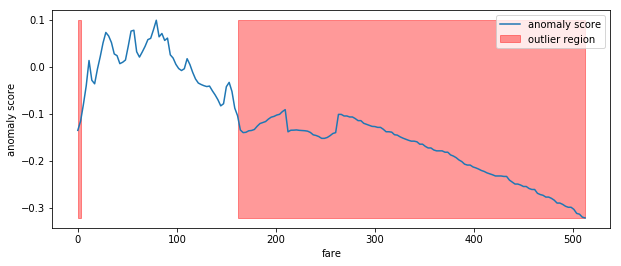

In [0]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df_Titanic['fare'].values.reshape(-1, 1))
xx = np.linspace(df_Titanic['fare'].min(), df_Titanic['fare'].max(), len(df_Titanic)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('fare')
plt.show();

In [0]:
# Vamos avaliar os dados do dataframe para fare > 200, por exemplo
df_Titanic.loc[df_Titanic['fare'] > 200].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
27,0,1,male,19.0,3,2,263.0000,S,First,man,True,C,Southampton,no,False
88,1,1,female,23.0,3,2,263.0000,S,First,woman,False,C,Southampton,yes,False
118,0,1,male,24.0,0,1,247.5208,C,First,man,True,B,Cherbourg,no,False
299,1,1,female,50.0,0,1,247.5208,C,First,woman,False,B,Cherbourg,yes,False
311,1,1,female,18.0,2,2,262.3750,C,First,woman,False,B,Cherbourg,yes,False


In [0]:
# Zoom na linha 27
df_Titanic.iloc[27]

survived                 0
pclass                   1
sex                   male
age                     61
sibsp                    0
parch                    0
fare                  33.5
embarked                 S
class                First
who                    man
adult_male            True
deck                     B
embark_town    Southampton
alive                   no
alone                 True
Name: 170, dtype: object

A região onde os dados têm baixa probabilidade de aparecer fica no lado direito da distribuição.

## Anomaly Detection para 'age'

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


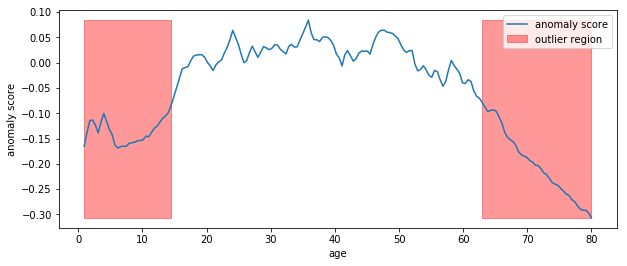

In [0]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df_Titanic['age'].values.reshape(-1, 1))
xx = np.linspace(df_Titanic['age'].min(), df_Titanic['age'].max(), len(df_Titanic)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('age')
plt.show();

Observe no gráfico acima que há duas regiões em que os dados têm baixa probabilidade de aparecer: uma no lado esquerdo da distribuição, outra no lado direito da distribuição.

In [0]:
# Avaliando os dados da cauda esquerda
df_Titanic.loc[df_Titanic['age'] < 15].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
10,1,3,female,4.0,1,1,16.7000,S,Third,child,False,G,Southampton,yes,False
183,1,2,male,1.0,2,1,39.0000,S,Second,child,False,F,Southampton,yes,False
193,1,2,male,3.0,1,1,26.0000,S,Second,child,False,F,Southampton,yes,False
205,0,3,female,2.0,0,1,10.4625,S,Third,child,False,G,Southampton,no,False
297,0,1,female,2.0,1,2,151.5500,S,First,child,False,C,Southampton,no,False


In [0]:
# Zoom na linha 3
df_Titanic.iloc[3]

survived                 1
pclass                   3
sex                 female
age                      4
sibsp                    1
parch                    1
fare                  16.7
embarked                 S
class                Third
who                  child
adult_male           False
deck                     G
embark_town    Southampton
alive                  yes
alone                False
Name: 10, dtype: object

In [0]:
# Avaliando dados da cauda direita
df_Titanic.loc[df_Titanic['age'] > 65].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
96,0,1,male,71.0,0,0,34.6542,C,First,man,True,A,Cherbourg,no,True
630,1,1,male,80.0,0,0,30.0000,S,First,man,True,A,Southampton,yes,True
745,0,1,male,70.0,1,1,71.0000,S,First,man,True,B,Southampton,no,False


In [0]:
# Zoom na linha 96
df_Titanic.iloc[96]

survived               0
pclass                 1
sex                 male
age                   58
sibsp                  0
parch                  0
fare                29.7
embarked               C
class              First
who                  man
adult_male          True
deck                   B
embark_town    Cherbourg
alive                 no
alone               True
Name: 487, dtype: object

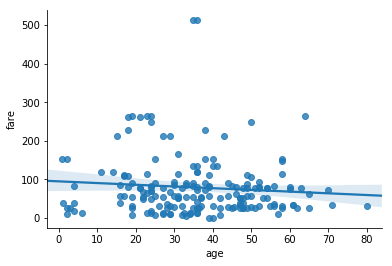

In [0]:
sns.regplot(x="age", y="fare", data=df_Titanic)
sns.despine()

In [0]:
cols = ['fare', 'age']
df_Titanic[cols].head()

,fare,age
1,71.2833,38.0
3,53.1000,35.0
6,51.8625,54.0
10,16.7000,4.0
11,26.5500,58.0


In [0]:
# Aplica a transformação MinMaxScaler() para que tenhamos os dados na mesma escala.
minmax = MinMaxScaler(feature_range=(0, 1))
df_Titanic[['fare','age']] = minmax.fit_transform(df_Titanic[['fare','age']])
df_Titanic[['fare','age']].head()

,fare,age
1,0.139136,0.468892
3,0.103644,0.430956
6,0.101229,0.671219
10,0.032596,0.038948
11,0.051822,0.721801


In [0]:
X1 = df_Titanic['age'].values.reshape(-1,1)
X2 = df_Titanic['fare'].values.reshape(-1,1)
X = np.concatenate((X1,X2),axis=1)

# CBLOF - Cluster-based Local Outlier Factor

OUTLIERS: 2 INLIERS: 180


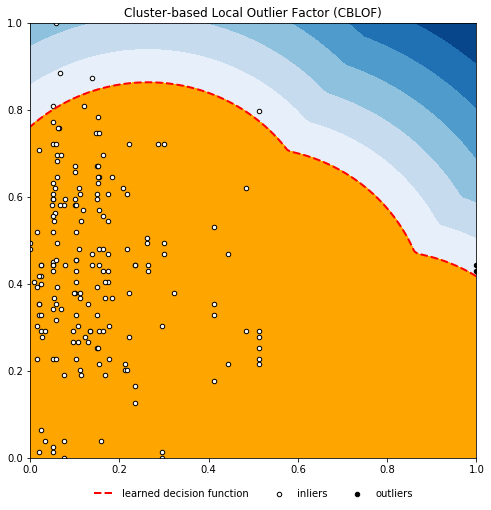

In [0]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

plt.figure(figsize=(8, 8))

df1 = df_Titanic
df1['outlier'] = y_pred.tolist()

inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)
    
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
# Use threshold para definir um ponto como inlier ou outlier
# threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# Calcula o Anomaly Score
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# Desenha a linha vermelha a partir do qual Anomaly Score = thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# Região onde Anomaly Score > threshold até max(Anomaly score)
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')
       
plt.axis('tight')   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=10),loc='upper center', frameon= False, bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show();

# HBOS - Histogram-based Outlier Detection

OUTLIERS: 2 INLIERS: 180


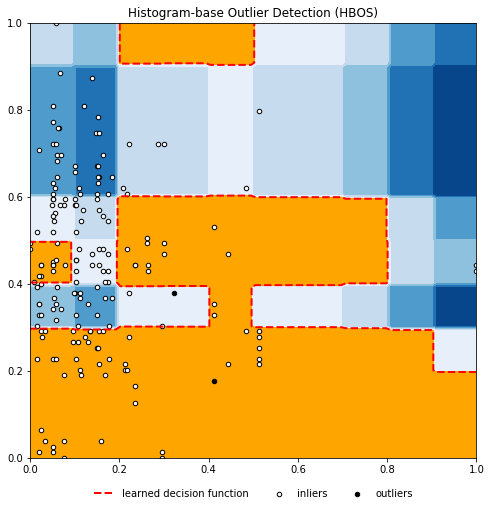

In [0]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = HBOS(contamination=outliers_fraction)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df_Titanic
df1['outlier'] = y_pred.tolist()
    
inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)
    
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
# threshold define se um ponto será outlier ou inlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# Calcula o Anomaly score
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

# Define a região azul tal que min(Anomaly score) < threshold
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# Desenha a linha a partir do queal Anomaly score = thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# Define a região laranja a partir do qual threshold < Anomaly score < max(Anomaly score)
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
     
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=10),loc='upper center', frameon= False, bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Histogram-base Outlier Detection (HBOS)')
plt.show();

# Isolation Forest

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


OUTLIERS:  2 INLIERS:  180


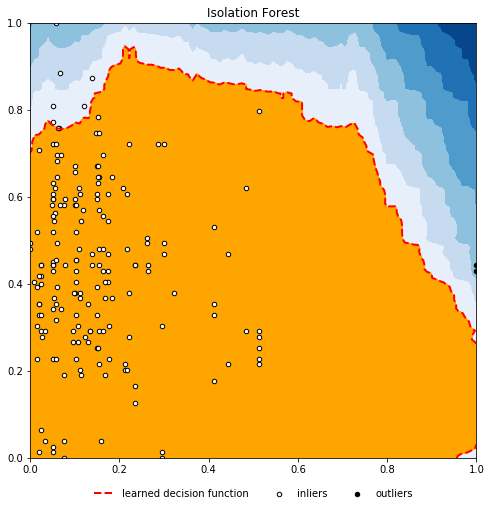

In [0]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = IForest(contamination=outliers_fraction,random_state=0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df_Titanic
df1['outlier'] = y_pred.tolist()
    
# fare - inlier feature 1,  age - inlier feature 2
inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)
    
# fare - outlier feature 1, age - outlier feature 2
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=10),loc='upper center', frameon= False, bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show();

# KNN - K-Nearest Neighbors

OUTLIERS:  2 INLIERS:  180


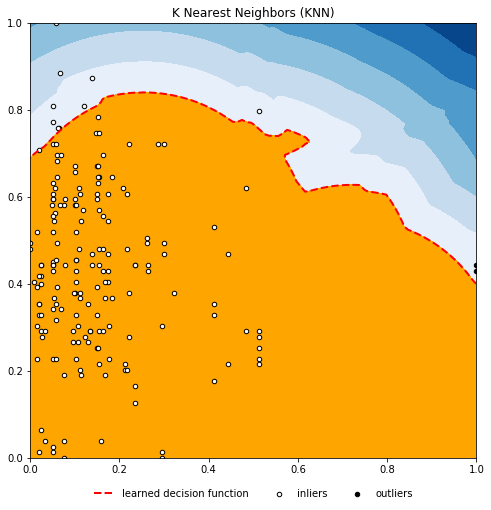

In [0]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = KNN(contamination=outliers_fraction)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df_Titanic
df1['outlier'] = y_pred.tolist()
    
inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)
    
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=10),loc='upper center', frameon= False, bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('K-Nearest Neighbors (KNN)')
plt.show();

In [0]:
# Selecionando alguns outliers...
df1.loc[df1['outlier'] == 1].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,outlier
679,1,1,male,0.443601,0,1,1.0,C,First,man,True,B,Cherbourg,yes,False,1
737,1,1,male,0.430956,0,0,1.0,C,First,man,True,B,Cherbourg,yes,True,1


In [0]:
# Olhando os dados originais...
df_Titanic.loc[679]

survived               1
pclass                 1
sex                 male
age             0.443601
sibsp                  0
parch                  1
fare                   1
embarked               C
class              First
who                  man
adult_male          True
deck                   B
embark_town    Cherbourg
alive                yes
alone              False
outlier                1
Name: 679, dtype: object